# Proyecto  ML  for engineering - Grupo 1 

## Integrantes
- Juan Camilo Rojas Hernández ()
- Sergio Andres Canar Lozano ()
- Wilman Sanchez Hernandez (`)

#### Imports

In [1]:
import os 
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from tqdm.notebook import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd
from dataset import CelebFacesDataset, dataloader_stats
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import wandb
from model import ResNet, ResidualBlock, get_resnet101_model, get_resnet18_model,  get_vgg16_model

#### Paths

In [2]:
this_dir = os.getcwd()
data_dir = os.path.join(this_dir, 'data')
img_dir = os.path.join(data_dir, 'face_recognition', 'Faces')

#### CUDA Settings

In [3]:
use_cuda = True
torch.cuda.manual_seed(42)
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")   
print(device) 

cuda


#### Create Datasets and Dataloaders

In [4]:
# Dataset 

transforms_set = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to tensor first
    transforms.Normalize(mean=[0.6389, 0.4773, 0.4056],
                         std=[0.2343, 0.1996, 0.1831]),
    #transforms.RandomCrop(107, pad_if_needed=True),
])

data = pd.read_csv(os.path.join(data_dir, 'face_recognition','dataset_faces.csv'))

dataset = CelebFacesDataset(df=data, root_dir=img_dir, transform=transforms_set)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = 31

model = get_resnet18_model(num_classes=num_classes)
# model = get_resnet101_model(num_classes=num_classes)
# model = get_vgg16_model(num_classes=num_classes)

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Model hyperparameters

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#### Train the model

In [9]:
def train(dataloader, model, criterion, optimizer, epoch, adjust_lr_fn=None, gamma=0.9, lr=0.001, wandb_log=False):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(dataloader):
        data = data.to(device)
        target = target.clone().detach().to(device) 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(dataloader.dataset)} '
                  f'({100. * batch_idx / len(dataloader):.0f}%)]\tLoss: {loss.item():.6f}')
        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    
    if wandb_log:
        wandb.log({"train_loss": avg_loss}, step=epoch)

    # Adjust learning rate after each epoch, if specified
    if adjust_lr_fn:
        adjust_lr_fn(optimizer, gamma, epoch, lr)

def test(dataloader, model, criterion, epoch, wandb_log=False):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            target = target.clone().detach().to(device) 
            output = model(data)
            test_loss += criterion(output, target).item()  # accumulate loss for the whole dataset
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
        
    test_loss /= len(dataloader)  # Now it's per batch, not per sample
    test_accuracy = 100. * correct / len(dataloader.dataset)
    
    # Calculate evaluation metrics
    precision_score_ = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall_score_ = recall_score(all_targets, all_preds, average='macro')
    f1_score_ = f1_score(all_targets, all_preds, average='macro')
    accuracy_score_ = accuracy_score(all_targets, all_preds)
    

    print(f'\nPrecision: {precision_score_:.2f}')
    print(f'Recall: {recall_score_:.2f}')
    print(f'F1 Score: {f1_score_:.2f}')
    print(f'Accuracy: {accuracy_score_:.2f}')
    print(f'====> Test set loss: {test_loss:.4f}')
    print(f'====> Test set accuracy: {test_accuracy:.2f}%')
    
    if wandb_log:
        wandb.log({"test_loss": test_loss, "test_accuracy": test_accuracy, "precision": precision_score_, "recall": recall_score_, "f1_score": f1_score_, "accuracy": accuracy_score_}, step=epoch)

    return test_loss, test_accuracy, precision_score_, recall_score_, f1_score_, accuracy_score_

def adjust_lr(optimizer, gamma, step, lr):
    lr = lr * (gamma ** step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


#### Train the model

In [10]:
torch.cuda.empty_cache()

In [11]:
best_accuracy = 0
epochs = 30
save_path = 'model.pth'

try:
    for epoch in tqdm(range(1, epochs + 1), desc="Epochs"):
        train(train_dataloader, model, criterion, optimizer, epoch, adjust_lr, 0.1, 0.001, wandb_log=True)
        
        test_loss, test_accuracy, precision_score_, recall_score_, f1_score_, accuracy_score_ = test(test_dataloader, model, criterion, epoch, wandb_log=True)
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), 'model.pth')
            print('Model saved to model.pth')
        else:
            adjust_lr(optimizer, 0.1, epoch, 0.001)

except KeyboardInterrupt:
    print('Training stopped')


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 1 [0/2048 (0%)]	Loss: 3.454968
Train Epoch: 1 [320/2048 (16%)]	Loss: 1.893797
Train Epoch: 1 [640/2048 (31%)]	Loss: 1.083227
Train Epoch: 1 [960/2048 (47%)]	Loss: 1.238727
Train Epoch: 1 [1280/2048 (62%)]	Loss: 0.981385
Train Epoch: 1 [1600/2048 (78%)]	Loss: 0.509849
Train Epoch: 1 [1920/2048 (94%)]	Loss: 0.944851
====> Epoch: 1 Average loss: 1.3342

Precision: 0.68
Recall: 0.59
F1 Score: 0.54
Accuracy: 0.60
====> Test set loss: 1.2777
====> Test set accuracy: 59.65%
Model saved to model.pth
Train Epoch: 2 [0/2048 (0%)]	Loss: 0.371091
Train Epoch: 2 [320/2048 (16%)]	Loss: 0.315088
Train Epoch: 2 [640/2048 (31%)]	Loss: 0.282129
Train Epoch: 2 [960/2048 (47%)]	Loss: 0.216152
Train Epoch: 2 [1280/2048 (62%)]	Loss: 0.061930
Train Epoch: 2 [1600/2048 (78%)]	Loss: 0.299636
Train Epoch: 2 [1920/2048 (94%)]	Loss: 0.107455
====> Epoch: 2 Average loss: 0.2204

Precision: 0.93
Recall: 0.93
F1 Score: 0.93
Accuracy: 0.93
====> Test set loss: 0.2649
====> Test set accuracy: 92.98%
Model

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = 'model.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=device, weights_only=True))
model.eval()

print('Model loaded')
print(model)

NameError: name 'model' is not defined

# FGSM Attack


$$perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))$$

In [13]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def denormalize(batch, mean=[0.6389, 0.4773, 0.4056], std=[0.2343, 0.1996, 0.1831]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device=device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device=device)
    return batch * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)

#### Test function

In [14]:
def test_corrupted(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    
    with tqdm(total=len(test_loader), desc="Epsilon") as pbar:
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data.requires_grad = True
            output = model(data)
            init_pred = output.max(1, keepdim=True)[1]
                            
            if init_pred.item() != target.item():
                continue
            
            loss = criterion(output, target)
            
            model.zero_grad()
            
            loss.backward()
            
            data_grad = data.grad.data
            
            data_denorm = denormalize(data)
            
            perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
            
            output = model(perturbed_data)
            
            final_pred = output.max(1, keepdim=True)[1]
            
            
            
            if final_pred.item() == target.item():
                correct += 1
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            pbar.update(1)
    
    final_acc = correct / float(len(test_loader))
    print(f'Epsilon: {epsilon}, Accuracy: {correct}/{len(test_loader)} = {final_acc}')
    
    return final_acc, adv_examples

In [15]:
accuracies = []
examples = []

test_dataloader_corrupted = DataLoader(test_dataset, batch_size=1, shuffle=False)

for eps in epsilons:
    acc, ex = test_corrupted(model, device, test_dataloader_corrupted, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0, Accuracy: 69/513 = 0.13450292397660818


Epsilon:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.05, Accuracy: 24/513 = 0.04678362573099415


Epsilon:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.1, Accuracy: 21/513 = 0.04093567251461988


Epsilon:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.15, Accuracy: 24/513 = 0.04678362573099415


Epsilon:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.2, Accuracy: 25/513 = 0.04873294346978557


Epsilon:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.25, Accuracy: 24/513 = 0.04678362573099415


Epsilon:   0%|          | 0/513 [00:00<?, ?it/s]

Epsilon: 0.3, Accuracy: 24/513 = 0.04678362573099415


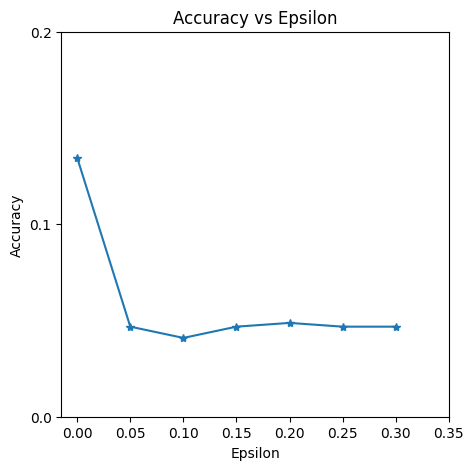

In [16]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, np.max(accuracies)+0.1, step=0.1))
plt.xticks(np.arange(0, np.max(epsilons)+0.1, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

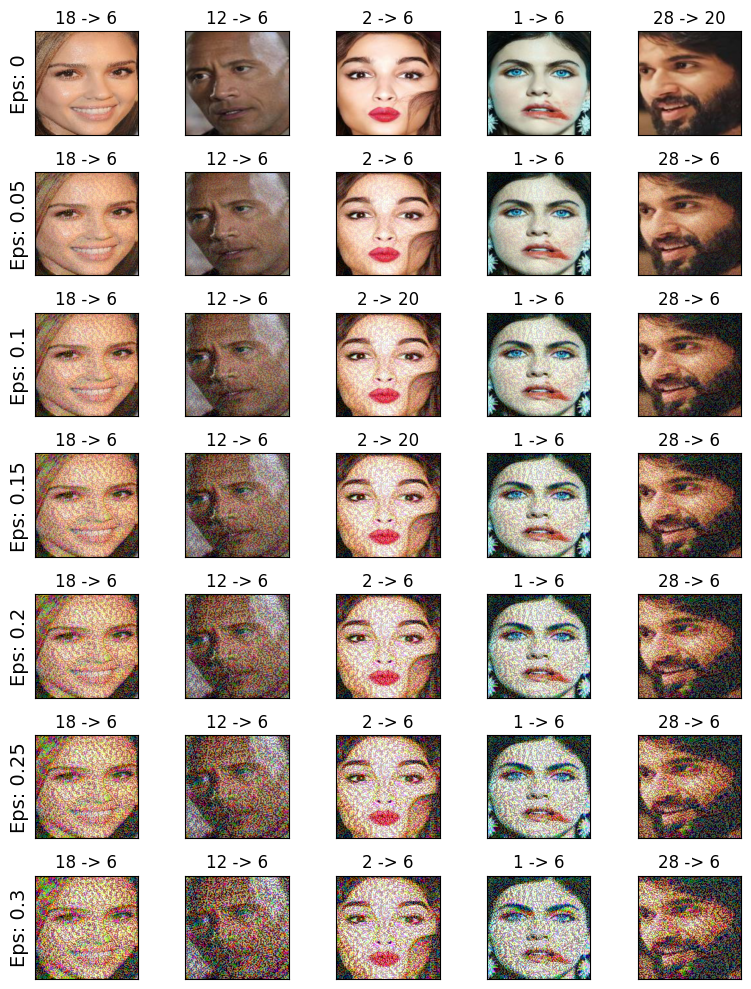

In [17]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()